In [217]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd       
import seaborn as sns       
import sklearn   

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# 1. Постановка задачи
**Задача**.  
Определить "престижность" квратиры по ее характеристикам.  
Предполагается что существует три уровня престижности: ниже среднего,cредняя и выше среднего.  
То есть перед нами задача классификации на 3 класса.  

**Данные**: В качетве обучающей выборки взят [набор данных о проданных квартрах](https://www.kaggle.com/gunhee/koreahousedata).</br>
Поскольку в самом датасете нет меток "престижности" в дальнейшем они будут искусственно сгенерированы на основе цен квартир на момент продажи. Соблюдены 2 уловия: разнородные признаки и наличие несбалансироыанных классов. 

# 2. Чтение данных

In [218]:
df = pd.read_csv('apartament_data.csv')
print(f'Число сэмлов = {df.shape[0]}')
print(f'Число признаков = {df.shape[1]}')
print(f'Типы признаков:')
[print('\tтип:', ttype, '\tчисло признаков:', num) 
    for ttype, num in zip(df.dtypes.value_counts().index, df.dtypes.value_counts())]
pass

Число сэмлов = 5891
Число признаков = 30
Типы признаков:
	тип: float64 	число признаков: 16
	тип: int64 	число признаков: 8
	тип: object 	число признаков: 6


#### Изменим тип категориальных признаков c object на category

In [219]:
object_cols = df.select_dtypes("object").columns
for col in object_cols:
    df[col] = df[col].astype('category')
[print('\tтип:', ttype, '\tчисло признаков:', num) 
    for ttype, num in zip(df.dtypes.value_counts().index, df.dtypes.value_counts())]
pass

	тип: float64 	число признаков: 16
	тип: int64 	число признаков: 8
	тип: category 	число признаков: 1
	тип: category 	число признаков: 1
	тип: category 	число признаков: 1
	тип: category 	число признаков: 1
	тип: category 	число признаков: 1
	тип: category 	число признаков: 1


# 3. Визуализация данных
#### Для удобства переименуем название признаков:

In [220]:
new_names = ['price', 'year_built', 'year_sold', 'month_sold', 'size', 'floor', 'hallway_type', 'heating_type',
              'apt_manage_type', 'n_ground_parking', 'n_basement_parking', 'time_to_bus', 
              'time_to_subway', 'n_apt', 'n_manager', 'n_elevators', 'subway_station', 'n_office', 'n_hospital',
              'n_dpartmentstore', 'n_mall', 'n_etc', 'n_park', 'n_elementary_school', 'n_middle_school',
              'n_high_school', 'n_university', 'n_facilities_in_apt','n_facilities', 'n_school']
rename_dict = {old_name: new_name for old_name, new_name in zip(df.columns, new_names)}
df = df.rename(columns=rename_dict)
df.head()

,price,year_built,year_sold,month_sold,size,floor,hallway_type,heating_type,apt_manage_type,n_ground_parking,...,n_mall,n_etc,n_park,n_elementary_school,n_middle_school,n_high_school,n_university,n_facilities_in_apt,n_facilities,n_school
0,141592,2006,2007,8,814,3,terraced,individual_heating,management_in_trust,111.0,...,1.0,1.0,0.0,3.0,2.0,2.0,2.0,5,6.0,9.0
1,51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80.0,...,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80.0,...,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
3,380530,2006,2007,8,2056,8,terraced,individual_heating,management_in_trust,249.0,...,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
4,221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523.0,...,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0


#### Здесь первый столбец - price будет использован для получения меток классов. Остальные 29 столбцов - признаки объектов. 

#### Перечислим какие признакиу нас есть: 

|Признак| Описание|Признак| Описание|
|:-------|:--------|:-------|:--------|
|**year_built**| Год постройки |**year_sold**| Год продажи |
|**month_sold**| Месяц продажи |**size**| Площадь |
|**floor**| Этаж |**hallway_type**| Тип прихожей |
|**heating_type**| Тип отопления  |**apt_manage_type**| менеджер продажи (собственник / агентсво) |
|**n_ground_parking**| Число наземных парковочных мест |**n_basement_parking**| Число подземных парковочных мест |
|**time_to_bus**| Веремя до автобусной остановки |**time_to_subway**|  Время до метро |
|**n_apt**| Число комнат |**n_manager**| Число менеджеров |
|**n_elevators**| Число лифтов |**subway_station**| Название ближайшей станции метро |
|**n_office**|  Число офисов неподалеку |**n_hospital**| Число больниц неподалеку |
|**n_dpartmentstore**| Число универмагов неподалеку |**n_mall**| Число торговых центров неподалеку |
|**n_etc**| Число прочих объектов инфрастуктуры неподалеку |**n_park**| Число парков неподалеку |
|**n_elementary_school**| Число начальных школ неподалеку |**n_middle_school**|  Число средних школ неподалеку |
|**n_high_school**| Число высших школ неподалеку |**n_university**| Число университетов неподалеку |
|**n_facilities_in_apt**| Общее число объектов инфрасктруктуры в самом доме |**n_facilities**| Общее число объектов инфрасктруктуры неподалеку|
|**n_school**| Общее число школ неподалеку|

# 4. Преобразуем цену квартиры в ее "престижность"
Для этого разобьем дипазон цен за квартиры на 3 диапазона с использованием квантилей 1-го и 3-го уровней тренировочных цен.  
Тем самым получим несбалансированные классы

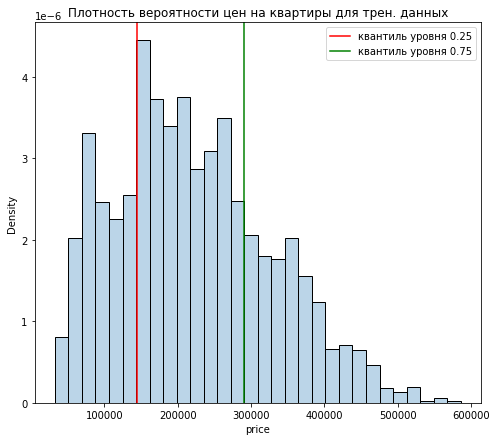

In [221]:
price = df.price
first_q = price.quantile(0.25)
third_q = price.quantile(0.75)

plt.rcParams["figure.figsize"] = (8,7)
sns.histplot(data=price, bins=30, alpha=0.3, stat='density')
plt.axvline(first_q, 0, 1200, c='r', label='квантиль уровня 0.25')
plt.axvline(third_q, 0, 1200, c='g', label='квантиль уровня 0.75')
plt.legend()
plt.title("Плотность вероятности цен на квартиры для трен. данных")
pass

In [222]:
# Разделение квартир на классы престижности: low, middle и hight для ВСЕХ сэмплов 
# используя квантили только ТРЕНИРОВОЧНЫХ данных
prestige = np.asarray(["middle"] * len(df))
prestige[list(df.price <= first_q)] = "low"
prestige[list(df.price > third_q)] = "hight"
# Добавление нового столбца prestige и удаление старого price
df.insert(0, "prestige", pd.Series(prestige))
df['prestige'] = df['prestige'].astype('category')
df = df.drop(['price'], axis=1)
# Проверка что наши классы несбалансированны (хотя это итак очевидно)
print("Доли квартир в общей выборке:")
df['prestige'].value_counts() 

Доли квартир в общей выборке:


middle    2953
low       1474
hight     1464
Name: prestige, dtype: int64

# 5. Разбиение данных на обучающую и тестовую выборки
Поскольку наши классы несбалансированны то используем параметр *stratify*, чтобы доли классов в тесте и трейне были одинаковыми. 

In [223]:
df_train, df_test = train_test_split(df,  test_size=0.2, random_state=42, stratify=df.prestige)
print(f"N_train = {len(df_train)}\nN_test = {len(df_test)}")

N_train = 4712
N_test = 1179


# 6. Проверим наличие пропущенных значений

In [224]:
print(f'Число попущенных значений в train: {sum(df_train.isnull().sum())}')
print(f'Число попущенных значений в test: {sum(df_test.isnull().sum())}')

Число попущенных значений в train: 0
Число попущенных значений в test: 0


# 7. Обнаружение выбросов для количественных признаков
Предположим выбростами являются обекты, у которых хотя бы по 1 признаку произошел выход за предедлы квантилей уровней [0.005, 0.995]

In [225]:
rows_to_drop = []
bad_cols = []
for col in df_train.select_dtypes("number").columns:
    indices = df_train[(df_train[col] < df_train[col].quantile(0.005)) |
                       (df_train[col] > df_train[col].quantile(0.995))].index
    if len(indices) > 0:
        print(f"Найдено {len(indices)} выбросов для признака {col}")
        rows_to_drop.extend(list(indices))
        bad_cols.append(col)
rows_to_drop = set(rows_to_drop)
print(f"Всего объектов-выбросов {len(rows_to_drop)} штук")

Найдено 22 выбросов для признака size
Найдено 24 выбросов для признака floor
Всего объектов-выбросов 46 штук


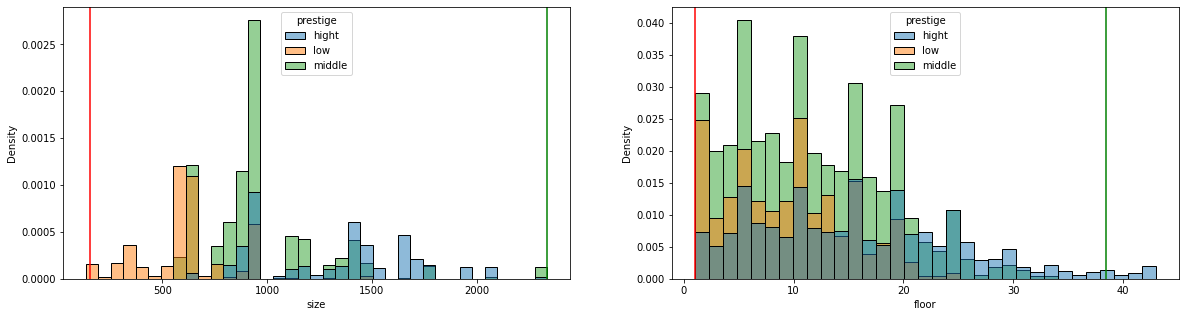

In [226]:
# Построим гистограммы признаков с выбросами
plt.rcParams["figure.figsize"] = (20,5)
fig, axes = plt.subplots(1, 2)
sns.histplot(data=df_train, x=bad_cols[0], ax=axes[0], stat='density', hue="prestige")
axes[0].axvline(df_train[bad_cols[0]].quantile(0.005), 0, 1200, c='r', label='квантиль уровня 0.005')
axes[0].axvline(df_train[bad_cols[0]].quantile(0.995), 0, 1200, c='g', label='квантиль уровня 0.995')

sns.histplot(data=df_train, x=bad_cols[1], ax=axes[1], stat='density', hue="prestige")
axes[1].axvline(df_train[bad_cols[1]].quantile(0.005), 0, 1200, c='r', label='квантиль уровня 0.005')
axes[1].axvline(df_train[bad_cols[1]].quantile(0.995), 0, 1200, c='g', label='квантиль уровня 0.995')
pass

Глядя на гистограммы теренировочных данных заметим что явных выбрасов не наблюдается.  
Те обекты что не вошли в диапазон квантелей уровней [0.005, 0.995] просто находятся в хвостах распределений и не являются выбросами. Поэтому удалять ничего не будем. 

## 8. Вычислим описательную статистику  + отбор признаков 
На тренировочных данных

In [227]:
df_train.iloc[:, :18].describe().round(3)

,year_built,year_sold,month_sold,size,floor,n_ground_parking,n_basement_parking,n_apt,n_manager,n_elevators,n_office
count,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000
mean,2002.922,2012.647,6.159,957.029,12.037,196.516,572.068,5.618,6.337,11.152,4.146
std,8.787,2.908,3.378,383.414,7.566,219.318,409.034,2.802,3.199,7.815,1.797
min,1978.000,2007.000,1.000,135.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000
25%,1993.000,2010.000,3.000,644.000,6.000,11.000,184.000,3.000,5.000,5.000,3.000
50%,2006.000,2013.000,6.000,910.000,11.000,100.000,536.000,7.000,6.000,11.000,5.000
75%,2007.000,2015.000,9.000,1149.000,17.000,249.000,798.000,8.000,8.000,16.000,5.000
max,2015.000,2017.000,12.000,2337.000,43.000,713.000,1321.000,13.000,14.000,27.000,7.000


In [228]:
df_train.iloc[:, 18:].describe().round(3)

,n_hospital,n_dpartmentstore,n_mall,n_etc,n_park,n_elementary_school,n_middle_school,n_high_school,n_university,n_facilities_in_apt,n_facilities,n_school
count,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.000,4712.00,4712.000,4712.000,4712.000
mean,1.298,0.892,0.940,1.957,0.656,3.024,2.421,2.662,2.77,5.816,9.889,10.878
std,0.480,0.814,0.403,2.206,0.662,0.953,1.040,1.560,1.49,2.330,3.460,4.443
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,1.000,0.000,0.000
25%,1.000,0.000,1.000,0.000,0.000,2.000,2.000,1.000,2.00,4.000,8.000,7.000
50%,1.000,1.000,1.000,1.000,1.000,3.000,3.000,2.000,2.00,5.000,9.000,10.000
75%,2.000,2.000,1.000,5.000,1.000,4.000,3.000,4.000,4.00,7.000,13.000,15.000
max,2.000,2.000,2.000,5.000,2.000,6.000,4.000,5.000,5.00,10.000,16.000,17.000


Проанализируем сатистику: 
* **count** для всех признаков имеет одниковое значение -> в очередной раз убеждаемся что пропущенных значений нет
* **std** для всех признаков (сильно) отличен от 0 -> каждый из признаков может быть полезен для классификации.
* **25%** горят что у четверти квартир нет поблизости парков и не более 1й больницы  
* **50%** (или медиана) говорит что средний человек продает квартиру площадью 910 кв.м. с 7 комнатами. Средняя квартира имеет неподалеку 9 обектов инфраструктуры (типа больниц и школ)
* **min** и **max** готорят что мы рассатриваем 2007-2017 года продажи квартир. Все квартиры были построены в пределах 1978-2015 годов. Их площадь варьируются в диапазоне [135, 2337] кв.м. (дада, оч большая площадь. Возможно авторы используют другую ед.измерения, но они ее не указали. Поэтому допустим то это кв.м.)

##  Проверим какие признаки вообще способны разделять объекты на классы

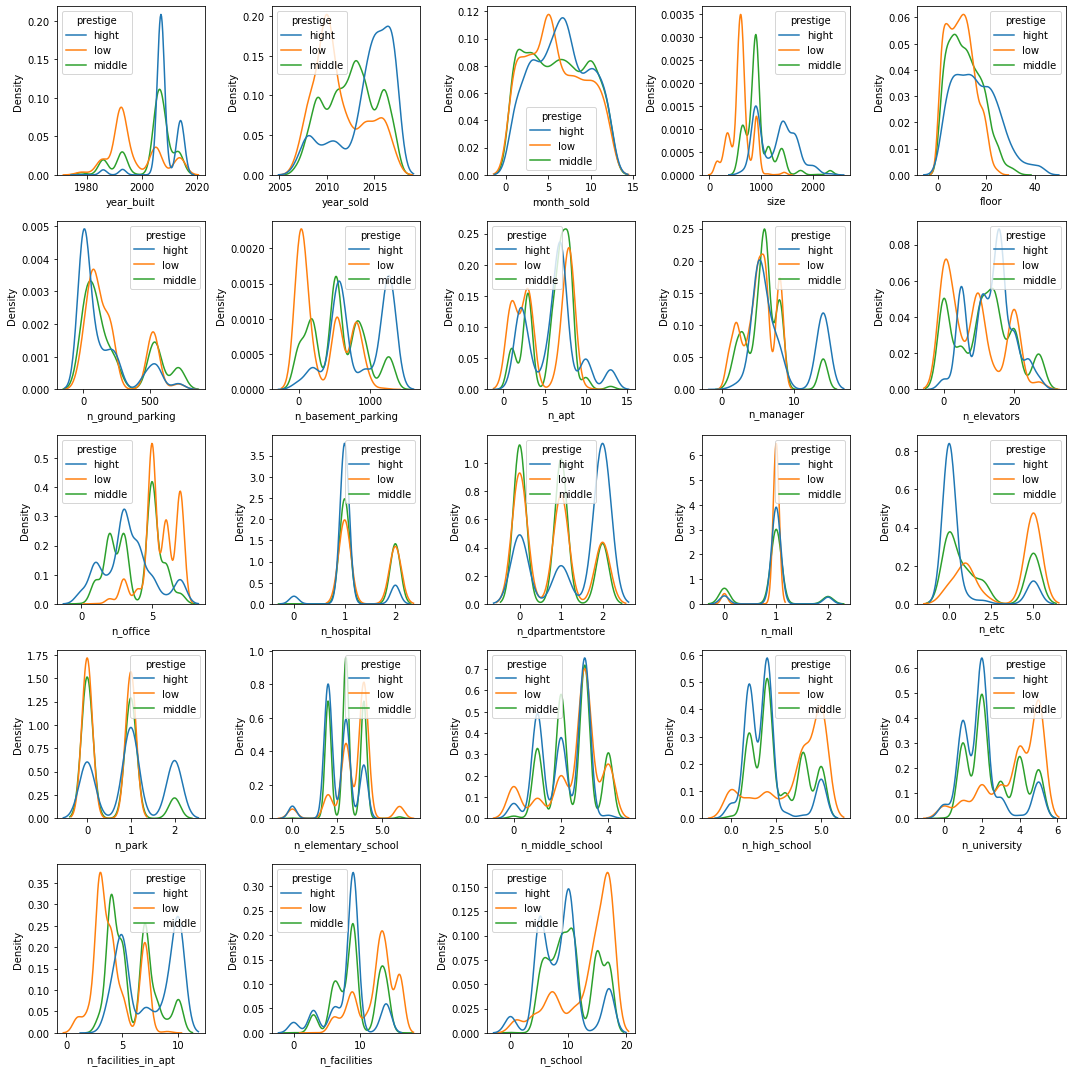

In [229]:
plt.rcParams["figure.figsize"] = (15,15)
fig, axes = plt.subplots(5, 5)
axes[4][4].remove()
axes[4][3].remove()
for i, col in enumerate(df.select_dtypes("number").columns): 
    sns.kdeplot(data=df_train, x=col, hue="prestige", ax=axes[i // 5][i % 5], common_norm=False)
plt.tight_layout()

Нет графика на котором все три кривые плотности вероянтностей совпали -> каждый признак несет в себе потенциально ценную информацию о разделении на классы по данному признаку.


# 9. Корреляционная матрица + отбор признаков

n_high_school       n_school               0.967557
n_university        n_school               0.940205
n_high_school       n_university           0.904174
n_office            n_facilities           0.892134
n_etc               n_high_school          0.845635
n_basement_parking  n_facilities_in_apt    0.837402
n_middle_school     n_school               0.808535
n_facilities        n_school               0.807238
n_etc               n_facilities           0.801281
dtype: float64

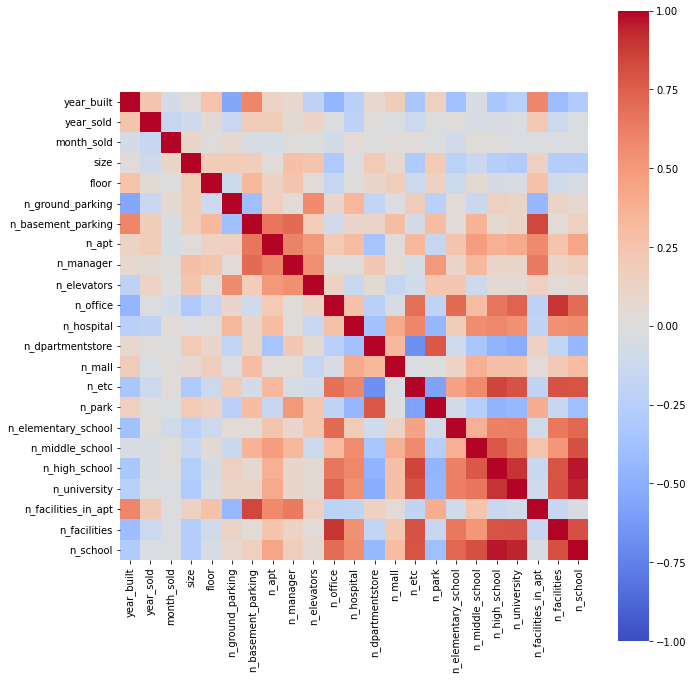

In [230]:
corr_mat = df_train.corr()
# Визуализация
plt.rcParams["figure.figsize"] = (10,10)
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.tight_layout()
# Анализ высоких (>0.8) корреляций
corr_mat.where(np.triu(abs(corr_mat)>0.8, k=1)).stack().sort_values(ascending=False)

Видим высокую положительную корреляцию у:
* `n_basement_parking` и `n_facilities_in_apt`. Что логично, так как число парковок в зданиях где находятся объекты инфраструктуры должно быть больше, чем в обычных жилых домах.
* Признак `n_school` отображает общее число школ неподалеку. Поэтому неудивительно что он сильно (до 96%) коррелирует с такими признаками как `n_elementary_school`, `n_middle_school`, `n_high_school` и `n_university`. Дропнем его, так как это просто суммирование соответвующих признаков (позже)
* `n_facilities` и `n_etc`. `N_facilities` - общее число объектов инфраструктуры, `n_etc` - число объектов инфраструктуры не вошедших в список `n_offic`, `n_hospital`, `n_dpartmentstore` и `n_mall`. Поэтому логичто что с ростом `n_etc` растет и `n_facilities`. Дропнем `n_facilities`, так как это просто суммирование соответвующих признаков (позже). 
* Остальные высокие корреляциии (между `n_etc`+`n_high_school` и `n_high_school`+`n_university`) сложно инерпретировать.

# 10. Анализ категориальных признаков

,prestige,hallway_type,heating_type,apt_manage_type,time_to_bus,time_to_subway,subway_station
count,5891,5891,5891,5891,5891,5891,5891
unique,3,3,2,2,3,5,8
top,middle,terraced,individual_heating,management_in_trust,0~5min,0-5min,Kyungbuk_uni_hospital
freq,2953,3564,5591,5542,4509,2759,1644


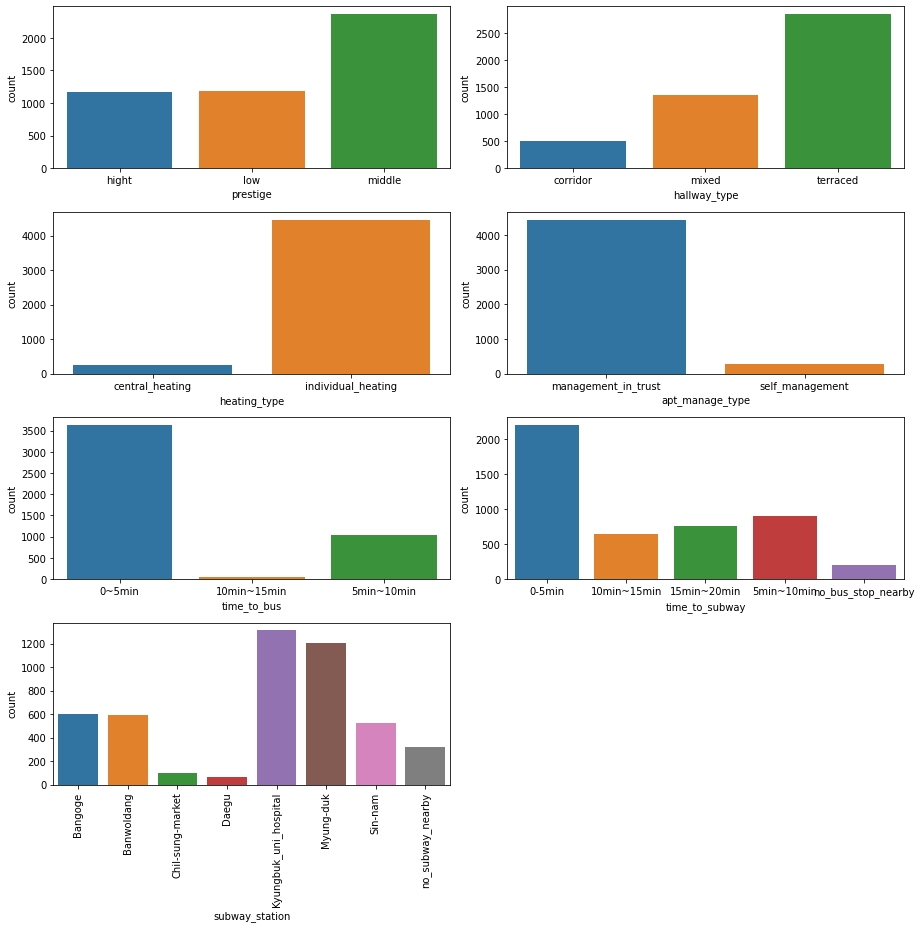

In [231]:
# Визуализируем статитику
categ_cols = df_train.select_dtypes("category").columns
plt.rcParams["figure.figsize"] = (13,13)
fig, axes = plt.subplots(4, 2)
axes[3][1].remove()
for i, col in enumerate(categ_cols):
    sns.countplot(data=df_train, x=col, ax=axes[i // 2][i % 2])
axes[3][0].set_xticklabels(axes[3][0].get_xticklabels(), rotation=90)
plt.tight_layout()

df.describe(include=['category'])

В большинстве случаев продаются дома в 5 минутах от метро или автобусной отсановки.  
Заметим что признаки **heating_type** и **apt_manage_type** принимают одно значение почти для всех обектов в выборке ->  
Они не несут полезной информации для разделения обектов на 3 класса -> Дропнем их. 

In [232]:
df_test = df_test.drop(['heating_type'], axis=1)
df_test = df_test.drop(['apt_manage_type'], axis=1)

df_train = df_train.drop(['heating_type'], axis=1)
df_train = df_train.drop(['apt_manage_type'], axis=1)
df_train.describe(include=['category'])

,prestige,hallway_type,time_to_bus,time_to_subway,subway_station
count,4712,4712,4712,4712,4712
unique,3,3,3,5,8
top,middle,terraced,0~5min,0-5min,Kyungbuk_uni_hospital
freq,2362,2848,3631,2203,1313


# 11. Бинаризация номинальных признаков 
Осталисть только небинарные категориальные признаки. Применим к ним применим метод бинаризации(one-hot encoding).

In [233]:
for col in ['hallway_type', 'time_to_bus', 'time_to_subway', 'subway_station']:
    df_train = pd.concat((df_train, pd.get_dummies(df_train[col])), axis=1)
    df_train = df_train.drop([col], axis=1)
    
    df_test = pd.concat((df_test, pd.get_dummies(df_test[col])), axis=1)
    df_test = df_test.drop([col], axis=1)

df_train.head()

,prestige,year_built,year_sold,month_sold,size,floor,n_ground_parking,n_basement_parking,n_apt,n_manager,...,5min~10min,no_bus_stop_nearby,Bangoge,Banwoldang,Chil-sung-market,Daegu,Kyungbuk_uni_hospital,Myung-duk,Sin-nam,no_subway_nearby
2429,middle,2006,2012,5,903,7,123.0,181.0,3.0,3.0,...,0,0,0,0,0,0,0,1,0,0
3102,middle,2006,2013,8,910,13,111.0,184.0,3.0,3.0,...,0,0,0,0,0,0,1,0,0,0
4607,middle,2013,2016,1,644,11,8.0,930.0,7.0,6.0,...,0,0,0,0,0,0,1,0,0,0
1277,low,2005,2010,5,572,2,67.0,798.0,8.0,6.0,...,1,0,1,0,0,0,0,0,0,0
5154,hight,2008,2016,10,914,19,197.0,475.0,6.0,6.0,...,0,0,0,0,0,0,0,0,1,0


# Отделение меток и признаков + стандартизация
Стандартизация на статистику тренировочных данных

Здесь она пригодится везде так как разброс std сильно варьируется от признака в признаку. Да и сами признаки могут иметь широкий диапазон min,max что не особо актуально для дальнейшего подсчета расстояний между признаковыми описаниями объектов в KNN.   

In [234]:
X_train = df_train.drop(['prestige'], axis=1)
y_train = np.asarray([1] * len(df_train))
y_train[df_train.prestige == "low"] = 0
y_train[df_train.prestige == "hight"] = 2

X_test = df_test.drop(['prestige'], axis=1)
y_test = np.asarray([1] * len(df_test))
y_test[df_test.prestige == "low"] = 0
y_test[df_test.prestige == "hight"] = 2

mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

X_train = (X_train - mean) / std
X_test =  (X_test  - mean) / std

X_test.describe()

,year_built,year_sold,month_sold,size,floor,n_ground_parking,n_basement_parking,n_apt,n_manager,n_elevators,...,5min~10min,no_bus_stop_nearby,Bangoge,Banwoldang,Chil-sung-market,Daegu,Kyungbuk_uni_hospital,Myung-duk,Sin-nam,no_subway_nearby
count,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,...,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000,1179.000000
mean,0.025996,0.077171,0.002534,-0.019025,-0.006871,-0.014417,-0.015959,-0.008513,-0.041390,-0.003951,...,0.007660,-0.029910,-0.023907,0.016938,-0.015284,0.008852,0.004675,0.005825,-0.011090,0.009027
std,1.014029,0.993309,1.015049,0.987835,0.989266,0.983803,0.995272,1.018687,0.960797,0.994526,...,1.006262,0.928602,0.972813,1.019113,0.946243,1.035981,1.002614,1.003566,0.986439,1.015640
min,-2.836117,-1.941610,-1.527183,-2.143973,-1.458816,-0.896033,-1.398585,-1.648551,-1.668479,-1.426943,...,-0.487514,-0.208308,-0.380852,-0.379390,-0.142656,-0.120088,-0.621456,-0.585457,-0.353685,-0.270349
25%,-1.129100,-0.910055,-0.935083,-0.816426,-0.797924,-0.845878,-0.948744,-0.934648,-0.417932,-0.787182,...,-0.487514,-0.208308,-0.380852,-0.379390,-0.142656,-0.120088,-0.621456,-0.585457,-0.353685,-0.270349
50%,0.350315,0.121501,-0.046933,-0.122659,-0.137031,-0.440075,-0.088179,0.493156,-0.105296,-0.019470,...,-0.487514,-0.208308,-0.380852,-0.379390,-0.142656,-0.120088,-0.621456,-0.585457,-0.353685,-0.270349
75%,0.577918,0.809205,0.841217,0.500689,0.656039,0.239304,0.552355,0.850107,0.519977,0.620291,...,-0.487514,-0.208308,-0.380852,-0.379390,-0.142656,-0.120088,1.608782,1.707705,-0.353685,-0.270349
max,1.374526,1.496909,1.729366,3.599168,3.960501,2.354953,1.830979,2.634863,2.395797,2.027764,...,2.050789,4.799576,2.625135,2.635254,7.008369,8.325482,1.608782,1.707705,2.826777,3.698138


# 12. Запуск KNN при разных K. 
# Ошибки на обучающей и тестовой выборке. 

Поскольку наши классы несбалансированны то fscore тоже считам используя доли классов как веса.

In [86]:
train_loss = np.zeros((2, 15, 5))
test_loss = np.zeros((2, 15, 5))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k in tqdm(range(1, 16)):
        for p in range(1, 6):
            for w in range(2):
                knn = KNeighborsClassifier(n_neighbors=k, weights=['distance', 'uniform'][w], p=p, n_jobs=8)
                knn.fit(X_train, y_train)
                train_predict = knn.predict(X_train)
                test_predict = knn.predict(X_test)
                train_loss[w][k-1][p-1] = f1_score(train_predict, y_train, average='weighted')
                test_loss[w][k-1][p-1] = f1_score(test_predict, y_test, average='weighted')

100%|███████████████████████████████████████████| 15/15 [09:14<00:00, 36.97s/it]


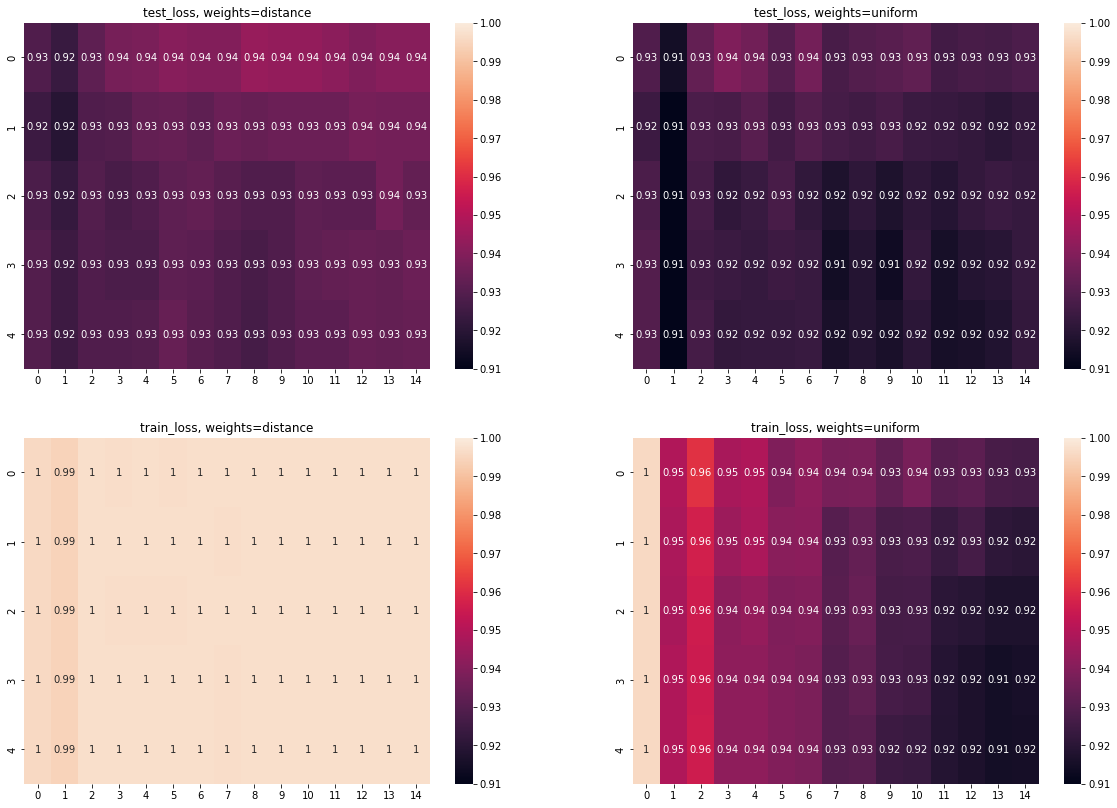

In [93]:
plt.rcParams["figure.figsize"] = (20,14)
fig, axes = plt.subplots(2, 2)
axes[0][0].set_title('test_loss, weights=distance')
sns.heatmap(test_loss[0].transpose(), annot=True, ax=axes[0][0], vmin=0.91, vmax=1)

axes[0][1].set_title('test_loss, weights=uniform')
sns.heatmap(test_loss[1].transpose(), annot=True, ax=axes[0][1], vmin=0.91, vmax=1)

axes[1][0].set_title('train_loss, weights=distance')
sns.heatmap(train_loss[0].transpose(), annot=True, ax=axes[1][0], vmin=0.91, vmax=1)

axes[1][1].set_title('train_loss, weights=uniform')
sns.heatmap(train_loss[1].transpose(), annot=True, ax=axes[1][1], vmin=0.91, vmax=1)
plt.show()

OX - число соседей k (нужно прибавить единицу)    
OY - степенный параметр для метрики Минковского p (нужно прибавить единицу)  

# Выводы 
1. Лучишими гиперпараметрами оказались число соседей k=9, степень степенный параметр для метрики Минковского p=1. Они позволяют достичь F1_score(average='weighted')=94% на тестовых и 100% на тренировочных. Использование взвешивания голосов соседей (weights='distance') улучшает классификацию.
1. Увеличение показателя степени Минковского ухудшает классификацию -> для принятия решений оптимальнее использовать простые ограничивающие формы поска k-соседей(в двумерии: при p=1-ромб, p<1-вогнутый ромб, p=2-круг, p > 2-сглаженный квадрат)  
1. При взвешивании голосов лучше всего срабатывают 9 соседей. Без взвешивания - 3 соседа. То есть объекты классов лучше всего сгруппированы в группы по 3 элемента. Но более надежную оценку дают 9 взвешенных соседей.  
1. Все значения 'train_loss, weights=distance' высокие - так как алгоритм уже знает этот объект и ставит этому объекту макимальный вес =1. Каждый семпл из тренировочных данных уже есть в пространстве признаков и не зависимо от параметра k, вес=1 назначается соответвующей точке в пространстве признаков. И поэтому тут 100% результат. 
1. Для 'train_loss, weights=uniform' получается 100% только при k=1, так как каждый объект голоует только сам за себя. В остальном мы видим как резко темнее область когда начинают голосовать более чем 6 соседей. Поэтому можем сделать предположение - в тренирововчной выборке данные хорошо сгруппированны по класса в группы из 6 элементов.  
1. Можно предположить что набор оптимальных гиперпараметров - выпуклая область в пространстве гиперпараметров. Такой вывод можно сделать глядя на рисунки для rest_loss: видны светлые окружности с наибольшим значением F1_score.

# 13. Попробуем удалить коррелированные признаки найденные ранее 

In [206]:
X_train = X_train.drop(['n_school'], axis=1)
X_train = X_train.drop(['n_facilities'], axis=1)

X_test = X_test.drop(['n_school'], axis=1)
X_test = X_test.drop(['n_facilities'], axis=1)

In [95]:
train_loss = np.zeros((2, 15, 5))
test_loss = np.zeros((2, 15, 5))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k in tqdm(range(1, 16)):
        for p in range(1, 6):
            for w in range(2):
                knn = KNeighborsClassifier(n_neighbors=k, weights=['distance', 'uniform'][w], p=p, n_jobs=8)
                knn.fit(X_train, y_train)
                train_predict = knn.predict(X_train)
                test_predict = knn.predict(X_test)
                train_loss[w][k-1][p-1] = f1_score(train_predict, y_train, average='weighted')
                test_loss[w][k-1][p-1] = f1_score(test_predict, y_test, average='weighted')

100%|███████████████████████████████████████████| 15/15 [09:15<00:00, 37.03s/it]


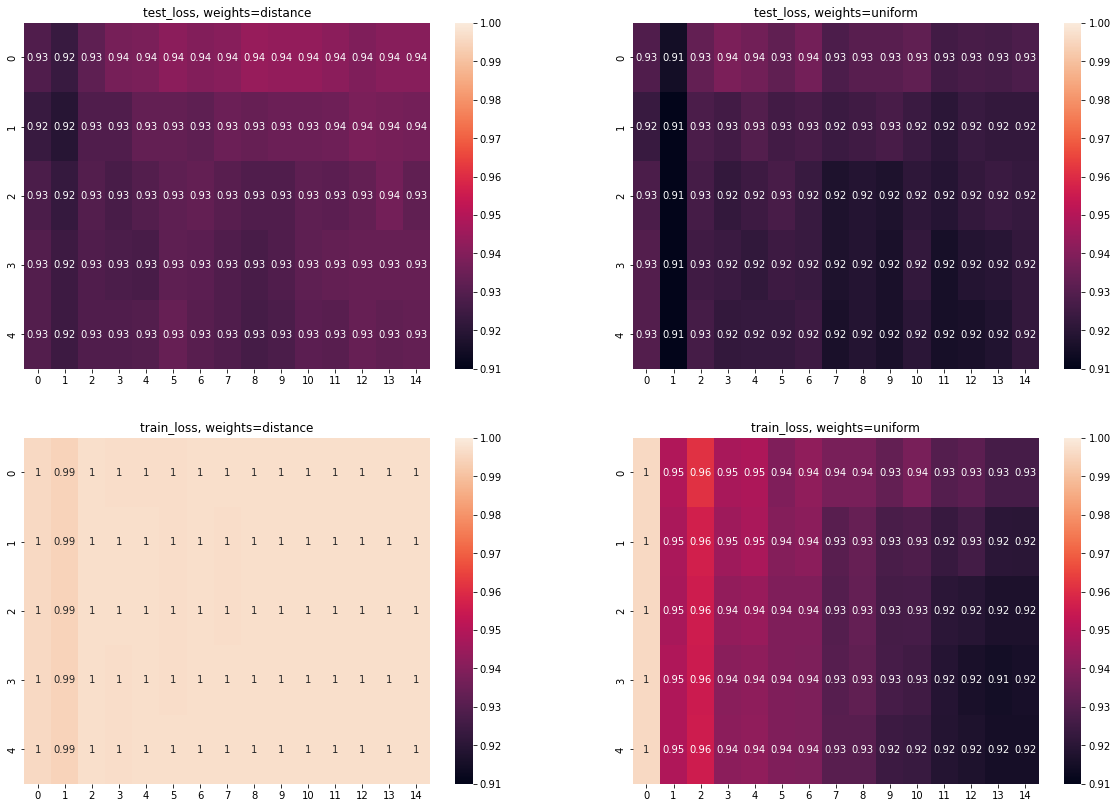

In [96]:
plt.rcParams["figure.figsize"] = (20,14)
fig, axes = plt.subplots(2, 2)
axes[0][0].set_title('test_loss, weights=distance')
sns.heatmap(test_loss[0].transpose(), annot=True, ax=axes[0][0], vmin=0.91, vmax=1)

axes[0][1].set_title('test_loss, weights=uniform')
sns.heatmap(test_loss[1].transpose(), annot=True, ax=axes[0][1], vmin=0.91, vmax=1)

axes[1][0].set_title('train_loss, weights=distance')
sns.heatmap(train_loss[0].transpose(), annot=True, ax=axes[1][0], vmin=0.91, vmax=1)

axes[1][1].set_title('train_loss, weights=uniform')
sns.heatmap(train_loss[1].transpose(), annot=True, ax=axes[1][1], vmin=0.91, vmax=1)
plt.show()

Результаты не ухудшились -> удаленные признаки были решающими или полезными  
Результаты не улучшились -> удаленные признаки не добавляли шума и не вносили помех в соседство  
Избавились от лишних признаков - очень даже хорошо 

# 14. Борьба с несбалансированностью
Частично это проблему решает взвешивание голосов. Но интерено как поведет себя KNN при наивной балансировке:  
* Недосэмлирование. В нашем случае это удаление половины middle сэмплов.  
Иммитация недосэмлирования на полной выборке при применении KNN для классификации:  
Когда мы будем считать число соседей для некоторого образца то с вероятностью 0.5 мы будем пропускать очередной объект middle. Тогда чтобы найти k объектов после недосэмплирования придется увеличивать радиус поиска. Что в итоге расширит пересечение границ принтия решений. 
* Пересемплирование. В нашем случае полное дублирование всех hight и low сэмлов.   
Иммитация пересэмлирования на полной выборке при применении KNN для классификации:  
Когда мы будем считать число соседей для некоторого образца то каждый hight и low сэмплы будут учитываться 2 раза. В результате радиус поска уменьшится. Объекты классов hight и low получат двойной вес за счет уменьшение веса middle объектов вдвое. В итоге границы принятий решений сузятся. и сэплы попдающие на эту границу будут отенесы к middle или hight. 

In [207]:
def train(X_train, y_train, X_test, y_test):
    train_loss = np.zeros((2, 15, 5))
    test_loss = np.zeros((2, 15, 5))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for k in tqdm(range(1, 16)):
            for p in range(1, 6):
                for w in range(2):
                    knn = KNeighborsClassifier(n_neighbors=k, weights=['distance', 'uniform'][w], p=p, n_jobs=8)
                    knn.fit(X_train, y_train)
                    train_predict = knn.predict(X_train)
                    test_predict = knn.predict(X_test)
                    train_loss[w][k-1][p-1] = f1_score(train_predict, y_train, average='weighted')
                    test_loss[w][k-1][p-1] = f1_score(test_predict, y_test, average='weighted')
                    
    plt.rcParams["figure.figsize"] = (20,14)
    fig, axes = plt.subplots(2, 2)
    axes[0][0].set_title('test_loss, weights=distance')
    sns.heatmap(test_loss[0].transpose(), annot=True, ax=axes[0][0], vmin=0.91, vmax=1)

    axes[0][1].set_title('test_loss, weights=uniform')
    sns.heatmap(test_loss[1].transpose(), annot=True, ax=axes[0][1], vmin=0.91, vmax=1)

    axes[1][0].set_title('train_loss, weights=distance')
    sns.heatmap(train_loss[0].transpose(), annot=True, ax=axes[1][0], vmin=0.91, vmax=1)

    axes[1][1].set_title('train_loss, weights=uniform')
    sns.heatmap(train_loss[1].transpose(), annot=True, ax=axes[1][1], vmin=0.91, vmax=1)
    plt.show()

# Недосэмлирование

In [215]:
np.random.seed(42)

cat_train = X_train.copy()
cat_train.insert(0, 'y', y_train)
remove_train_n = int(sum(cat_train.y == 1) * 0.5)
train_drop_indices = np.random.choice(cat_train[cat_train.y == 1.].index, remove_train_n, replace=False)
cat_train = cat_train.drop(train_drop_indices)

cat_test = X_test.copy()
cat_test.insert(0, 'y', y_test)
remove_test_n = int(sum(cat_test.y == 1) * 0.5)
test_drop_indices = np.random.choice(cat_test[cat_test.y == 1.].index, remove_test_n, replace=False)
cat_test = cat_test.drop(test_drop_indices)

print(cat_train.y.value_counts())
print(cat_test.y.value_counts())

1    1181
0    1179
2    1171
Name: y, dtype: int64
1    296
0    295
2    293
Name: y, dtype: int64


100%|███████████████████████████████████████████| 15/15 [05:07<00:00, 20.48s/it]


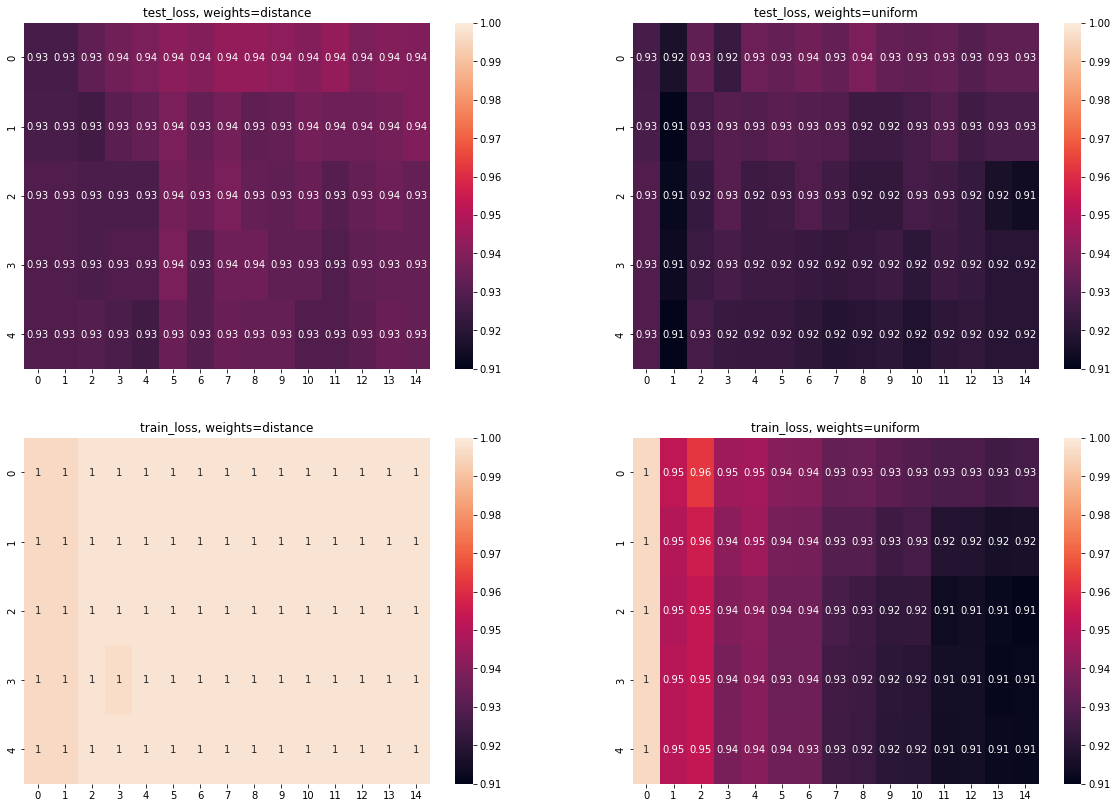

In [213]:
X_test_drop, y_test_drop = cat_test.drop('y', axis=1), cat_test.y
X_train_drop, y_train_drop = cat_train.drop('y', axis=1), cat_train.y
train(X_train_drop, y_train_drop, X_test_drop, y_test_drop)

Видим что на тестовой выборке fscore повисился (график стал в целом чуть светлее). А на тренировочной выборке при равномерном учитывании голосов fscore - не изменился. Значит мы сделали полезное проебразование.  

# Пересемплирование

In [239]:
np.random.seed(42)

cat_train = X_train.copy()
cat_train.insert(0, 'y', y_train)
cat_train = pd.concat([cat_train, cat_train[cat_train.y == 0], cat_train[cat_train.y == 2]], ignore_index=True)

cat_test = X_test.copy()
cat_test.insert(0, 'y', y_test)
cat_test =  pd.concat([cat_test, cat_test[cat_test.y == 0], cat_test[cat_test.y == 2]], ignore_index=True)

print(cat_train.y.value_counts())
print(cat_test.y.value_counts())

1    2362
0    2358
2    2342
Name: y, dtype: int64
1    591
0    590
2    586
Name: y, dtype: int64


100%|███████████████████████████████████████████| 15/15 [23:06<00:00, 92.43s/it]


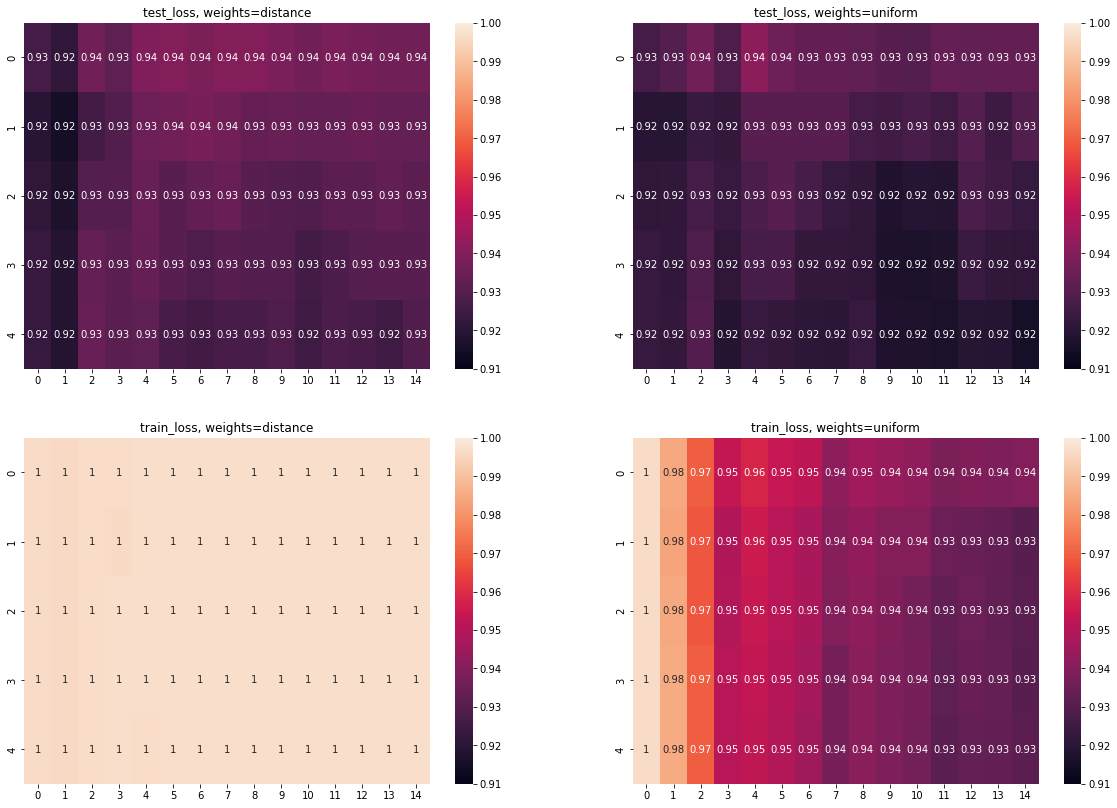

In [240]:
X_test_drop, y_test_drop = cat_test.drop('y', axis=1), cat_test.y
X_train_drop, y_train_drop = cat_train.drop('y', axis=1), cat_train.y
train(X_train_drop, y_train_drop, X_test_drop, y_test_drop)

Видим что на тестовой выборке fscore понизился (график стал в целом темнее). А на тренировочной выборке при равномерном учитывании голосов fscore - повысился. Похоже на тенденцию к переобучению. Когда мы подстраиваемся под тренировочный набор данных. В итоге наверное луче использовать недосемплирование